#Using Siphon to get NEXRAD Level 3 data from a TDS

###Objectives:
1. Learn more about Siphon
2. Use the RadarServer class to retrieve radar data from a TDS
3. Plot this data using numpy arrays and matplotlib

###Introduction:
Siphon is a python package that makes downloading data from Unidata data technologies a breeze! In our examples, we'll focus on interacting with the netCDF Subset Service (NCSS) as well as the radar server to retrieve grid data and radar data.

**But first!**
Bookmark these resources for when you want to use Siphon later!
+ [latest Siphon documentation](http://siphon.readthedocs.org/en/latest/)
+ [Siphon github repo](https://github.com/Unidata/siphon)
+ [TDS documentation](http://www.unidata.ucar.edu/software/thredds/v4.6/tds/TDS.html)
+ [netCDF subset service documentation](http://www.unidata.ucar.edu/software/thredds/current/tds/reference/NetcdfSubsetServiceReference.html)

First create an instance of RadarServer to point to the appropriate radar server access URL. This hard-coding of a point should really be replaced by scanning the top-level catalog, but that is still todo.

In [1]:
%matplotlib inline
from siphon.radarserver import RadarServer
rs = RadarServer('http://thredds.ucar.edu/thredds/radarServer/nexrad/level3/IDD/')

Look at the values available in this dataset

In [2]:
rs.variables

{'DAA',
 'DHR',
 'DOD',
 'DPA',
 'DPR',
 'DSD',
 'DSP',
 'DTA',
 'DU3',
 'DU6',
 'DVL',
 'EET',
 'HHC',
 'N0C',
 'N0H',
 'N0K',
 'N0M',
 'N0Q',
 'N0R',
 'N0S',
 'N0U',
 'N0V',
 'N0X',
 'N0Z',
 'N1C',
 'N1H',
 'N1K',
 'N1M',
 'N1P',
 'N1Q',
 'N1S',
 'N1U',
 'N1X',
 'N2C',
 'N2H',
 'N2K',
 'N2M',
 'N2Q',
 'N2S',
 'N2U',
 'N2X',
 'N3C',
 'N3H',
 'N3K',
 'N3M',
 'N3Q',
 'N3S',
 'N3U',
 'N3X',
 'NAC',
 'NAH',
 'NAK',
 'NAM',
 'NAQ',
 'NAU',
 'NAX',
 'NBC',
 'NBH',
 'NBK',
 'NBM',
 'NBQ',
 'NBU',
 'NBX',
 'NCR',
 'NET',
 'NMD',
 'NST',
 'NTP',
 'NVL',
 'NVW',
 'OHA',
 'PTA'}

Create a new query object to help request the data. Using the chaining methods, ask for data from radar FTG (Denver) for now for the product N0Q, which is reflectivity data for the lowest tilt. We see that when the query is represented as a string, it shows the encoded URL.

In [3]:
from datetime import datetime
query = rs.query()
query.stations('FTG').time(datetime(2015, 7, 15, 22)).variables('N0Q')

var=N0Q&time=2015-07-15T22%3A00%3A00&stn=FTG

We can use the RadarServer instance to check our query, to make sure we have required parameters and that we have chosen valid station(s) and variable(s)


In [4]:
rs.validate_query(query)

True

Make the request, which returns an instance of TDSCatalog. This handles parsing the catalog

In [5]:
catalog = rs.get_catalog(query)

We can look at the datasets on the catalog to see what data we found by the query. We find one NIDS file in the return

In [6]:
catalog.datasets

{'Level3_FTG_N0Q_20150715_2159.nids': <siphon.catalog.Dataset at 0x10b9695f8>}

We can pull that dataset out of the dictionary and look at the available access URLs. We see URLs for OPeNDAP, CDMRemote, and HTTPServer (direct download).

In [7]:
ds = list(catalog.datasets.values())[0]
ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/nexrad/level3/IDD/N0Q/FTG/20150715/Level3_FTG_N0Q_20150715_2159.nids',
 'HTTPServer': 'http://thredds.ucar.edu/thredds/fileServer/nexrad/level3/IDD/N0Q/FTG/20150715/Level3_FTG_N0Q_20150715_2159.nids',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/nexrad/level3/IDD/N0Q/FTG/20150715/Level3_FTG_N0Q_20150715_2159.nids'}

We'll use the CDMRemote reader in Siphon and pass it the appropriate access URL.

In [8]:
from siphon.cdmr import Dataset
data = Dataset(ds.access_urls['CdmRemote'])

The CDMRemote reader provides an interface that is almost identical to the usual python NetCDF interface. We pull out the variables we need for azimuth and range, as well as the data itself.

In [9]:
rng = data.variables['gate'][:]
az = data.variables['azimuth'][:]
ref = data.variables['BaseReflectivityDR'][:]

Then convert the polar coordinates to Cartesian

In [10]:
import numpy as np
x = rng * np.sin(np.deg2rad(az))[:, None]
y = rng * np.cos(np.deg2rad(az))[:, None]
ref = np.ma.array(ref, mask=np.isnan(ref))

Finally, we plot them up using matplotlib and cartopy.

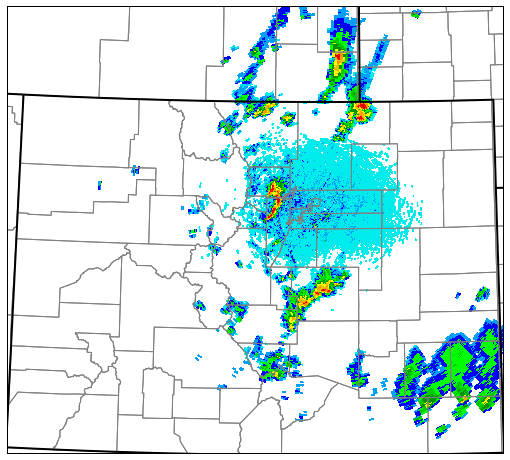

In [11]:
import matplotlib.pyplot as plt
import cartopy
from metpy.plots import ctables  # For NWS colortable

# Create projection centered on the radar. This allows us to use x
# and y relative to the radar.
proj = cartopy.crs.LambertConformal(central_longitude=data.RadarLongitude,
                                    central_latitude=data.RadarLatitude)

# New figure with specified projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Grab state borders
state_borders = cartopy.feature.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lines',
    scale='50m', facecolor='none')
ax.add_feature(state_borders, edgecolor='black', linewidth=2, zorder=2)

# Counties
counties = cartopy.io.shapereader.Reader('data/counties.shp')
ax.add_geometries(counties.geometries(), cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='grey', zorder=1)

# Set limits in lat/lon space
ax.set_extent([-109.03, -102.03, 37, 42])

norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)
ax.pcolormesh(x, y, ref, cmap=cmap, norm=norm, zorder=0)